In [301]:
import numpy as np
import pandas as pd
import re
#from sentiment_utils import *
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
np.random.seed(1)
from sklearn.model_selection import train_test_split

#from emo_utils import *
import matplotlib.pyplot as plt

In [302]:
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words)

def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [303]:
train_df = pd.read_csv(r"C:\Users\Siddharth Tripathi\Desktop\DataScience_Pranjal\Kaggle_assessment\sentiment-analysis-msa-phase-2\train.csv")
train_df.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


In [304]:
Mood = train_df['sentiment'].value_counts()

Text(0.5, 1.0, 'Mood Distribution')

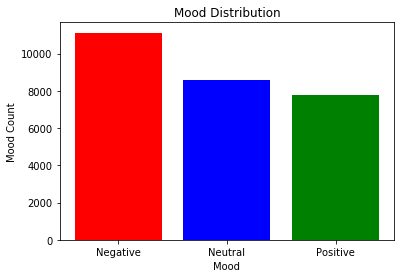

In [305]:
index = [1,2,3]
plt.bar(index,Mood,color=['r','b','g'])
plt.xticks(index,['Negative','Neutral','Positive'])
plt.xlabel('Mood')
plt.ylabel('Mood Count')
plt.title('Mood Distribution')

In [306]:
train_df.dtypes

textID       object
text         object
sentiment    object
dtype: object

In [307]:
train_df = train_df[['text', 'sentiment']]
train_df.text = train_df.text.apply(str)
train_df.text = train_df.text.apply(remove_mentions)
train_df.loc[:,'sentiment'] = train_df.sentiment.map({'negative':0,'neutral':1,'positive':2})
#train_df = train_df.drop(['airline_sentiment'], axis=1)
train_df.head()

,text,sentiment
0,"I`d have responded, if I were going",1
1,Sooo SAD I will miss you here in San Diego!!!,0
2,my boss is bullying me...,0
3,what interview! leave me alone,0
4,"Sons of ****, why couldn`t they put them on t...",0


In [308]:
raw_docs_train = train_df["text"].values
sentiment_train = train_df['sentiment'].values

maxLen = len(max(raw_docs_train, key=len).split())

In [309]:
print(maxLen)

29


In [310]:
X_train, X_test, Y_train, Y_test = train_test_split(raw_docs_train, sentiment_train, 
                                                  stratify=sentiment_train, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)
print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]

# Train data samples: (24732,)
# Test data samples: (2749,)


In [311]:
num_labels = len(np.unique(sentiment_train))
Y_oh_train = np_utils.to_categorical(Y_train, num_labels)
Y_oh_test = np_utils.to_categorical(Y_test, num_labels)
print(Y_oh_train.shape)

(24732, 3)


In [312]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map


word_to_index, index_to_word, word_to_vec_map = read_glove_vecs(r'C:\Users\Siddharth Tripathi\Desktop\DataScience_Pranjal\Kaggle_assessment\sentiment-analysis-msa-phase-2\glove.6B\glove.6B.50d.txt')

In [313]:
word = "cucumber"
index = 289846
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(index) + "th word in the vocabulary is", index_to_word[index])

the index of cucumber in the vocabulary is 113317
the 289846th word in the vocabulary is potatos


In [314]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =[word.lower().replace('\t', '') for word in X[i].split(' ') if word.replace('\t', '') != '']
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            try:
                X_indices[i, j] = word_to_index[w]
            except: 0
            # Increment j to j + 1
            j = j+1
    
    return X_indices

In [315]:
# Create Keras Embedding layer
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len,emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    embedding_layer = Embedding(vocab_len, emb_dim, trainable = False)
    ### END CODE HERE ###

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [316]:
def ltsm_model(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the ltsm_model model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    ### START CODE HERE ###
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices =  Input(shape=input_shape, dtype='int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer, you get back the embeddings
    embeddings = embedding_layer(sentence_indices)   
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # Be careful, the returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with softmax activation to get back a batch of 5-dimensional vectors.
    X = Dense(3, activation=None)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=[sentence_indices], outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [317]:
model = ltsm_model((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 29)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 29, 50)            20000050  
_________________________________________________________________
lstm_17 (LSTM)               (None, 29, 128)           91648     
_________________________________________________________________
dropout_17 (Dropout)         (None, 29, 128)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 387 

In [318]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [319]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxLen)
print(X_train_indices.shape)


(24732, 29)


In [320]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(X_train_indices, y=Y_oh_train, batch_size=5, epochs=20, 
          verbose=1, validation_data=(X_test_indices, Y_oh_test), callbacks=[earlystop])

Train on 24732 samples, validate on 2749 samples
Epoch 1/20
24732/24732 [==============================] - 212s 9ms/step - loss: 0.9404 - accuracy: 0.5566 - val_loss: 0.8605 - val_accuracy: 0.6402
Epoch 2/20
24732/24732 [==============================] - 206s 8ms/step - loss: 0.8376 - accuracy: 0.6359 - val_loss: 0.8369 - val_accuracy: 0.6424
Epoch 3/20
24732/24732 [==============================] - 200s 8ms/step - loss: 0.7984 - accuracy: 0.6590 - val_loss: 0.8050 - val_accuracy: 0.6548
Epoch 4/20
24732/24732 [==============================] - 201s 8ms/step - loss: 0.7677 - accuracy: 0.6764 - val_loss: 0.7702 - val_accuracy: 0.6704
Epoch 5/20
24732/24732 [==============================] - 197s 8ms/step - loss: 0.7365 - accuracy: 0.6905 - val_loss: 0.8828 - val_accuracy: 0.5973
Epoch 6/20
24732/24732 [==============================] - 197s 8ms/step - loss: 0.7083 - accuracy: 0.7056 - val_loss: 0.7747 - val_accuracy: 0.6672
Epoch 7/20
24732/24732 [==============================] - 197s 

In [321]:
x_test = np.array(['Last session of the day  http://twitpic.com/67ezh'])
X_test_indices = sentences_to_indices(x_test, word_to_index, maxLen)
print(x_test[0] +' '+  str(np.argmax(model.predict(X_test_indices))))

Last session of the day  http://twitpic.com/67ezh 1


In [322]:
train_df1 = pd.read_csv(r"C:\Users\Siddharth Tripathi\Desktop\DataScience_Pranjal\Kaggle_assessment\sentiment-analysis-msa-phase-2\test.csv")
train_df1.head()

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!


In [323]:
train_df1.text = train_df1.text.apply(str)
train_df1.text = train_df1.text.apply(remove_mentions)

In [324]:
raw_docs_train1 = train_df1["text"].values
maxLen1 = len(max(raw_docs_train1, key=len).split())
print(maxLen1)

20


In [325]:
X_train_indices1 = sentences_to_indices(raw_docs_train1, word_to_index, 29)

In [326]:
X_train_indices1.shape

(3534, 29)

In [327]:
model.predict(X_train_indices1)

array([[8.6936086e-02, 8.3215010e-01, 8.0913760e-02],
       [1.6314657e-03, 1.0326652e-02, 9.8804188e-01],
       [9.9129796e-01, 8.1022503e-03, 5.9983617e-04],
       ...,
       [5.8848321e-01, 3.6583227e-01, 4.5684539e-02],
       [7.6659261e-03, 4.7881305e-02, 9.4445282e-01],
       [1.1322093e-02, 2.7289104e-01, 7.1578681e-01]], dtype=float32)

In [328]:
my_arr=model.predict(X_train_indices1)

In [329]:
final = pd.DataFrame(my_arr)

In [330]:
# for x in final:
pred=[]
for x in my_arr:
    pred.append(list(x).index(x.max()))

In [331]:
print(pred)

[1, 2, 0, 2, 2, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 1, 2, 1, 1, 2, 2, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 1, 0, 1, 1, 2, 1, 0, 2, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 2, 2, 1, 0, 1, 1, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 0, 2, 0, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 0, 0, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1, 1, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 1, 1, 2, 0, 2, 1, 0, 0, 1, 1, 1, 2, 1, 1, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 0, 2, 2, 2, 0, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 1, 1, 

In [332]:
train_df1.head()

,textID,text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!


In [333]:
train_df1['sentiment']=pred

In [334]:
train_df1.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,1
1,96d74cb729,Shanghai is also really exciting (precisely -...,2
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",0
3,01082688c6,happy bday!,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,2


In [335]:
train_df1.drop(columns=['text'])

,textID,sentiment
0,f87dea47db,1
1,96d74cb729,2
2,eee518ae67,0
3,01082688c6,2
4,33987a8ee5,2
...,...,...
3529,e5f0e6ef4b,0
3530,416863ce47,2
3531,6332da480c,0
3532,df1baec676,2


In [336]:
def convert_back(inp):
    if(inp==1):
        return 'neutral'
    elif(inp==2):
        return 'positive'
    elif(inp==0):
        return 'negative'

    
    
train_df1['sentiment']=train_df1.sentiment.apply(convert_back)
train_df1.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [337]:
train_df1.to_csv(r'C:\Users\Siddharth Tripathi\Desktop\DataScience_Pranjal\Kaggle_assessment\sentiment-analysis-msa-phase-2\final1.csv')